# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [ ]:
#!pip install implicit

In [1]:
import src.recommenders as rc
import src.metrics as m

In [2]:
def prefilter_items(data, take_n_popular=5000, item_features=None):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]

    # Уберем товары, которые не продавались за последние 12 месяцев

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features. \
                                       groupby('department')['item_id'].nunique(). \
                                       sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[
            item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]

    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Уберем слишком дорогие товарыs
    data = data[data['price'] < 50]

    # Возбмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()

    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
    
    return data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
# from src.metrics import precision_at_k, recall_at_k
# from src.utils import prefilter_items
# from src.recommenders import MainRecommender

In [4]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

In [6]:
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

In [7]:
data_train_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50


In [8]:
n_items_after = data_train_lvl_1['item_id'].nunique()

In [9]:
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [10]:
recommender = rc.MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [11]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 1106523, 844179]

In [12]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [13]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 844179, 1078652, 15778319]

In [14]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 1096573, 835351, 861494, 821741]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [15]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(5)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


In [16]:
# your_code
from src.metrics import recall_at_k

In [17]:
data_train_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50


In [18]:
data_train_lvl_1.shape

(861404, 13)

In [19]:
result_lvl_1 = data_train_lvl_1.groupby('user_id')['item_id'].unique().reset_index()

In [20]:
result_lvl_1.head()

,user_id,item_id
0,1,"[825123, 999999, 845307, 852014, 856942, 99102..."
1,2,"[930118, 999999, 5567582, 5568489, 5569230, 93..."
2,3,"[866211, 1089954, 1118235, 1121321, 12132312, ..."
3,4,"[891423, 907631, 910109, 999999, 939907, 94453..."
4,5,"[999999, 825538, 1002499, 870826, 889509, 9417..."


In [21]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [22]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [23]:
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x:recommender.get_similar_items_recommendation(x, N=50))

In [24]:
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [25]:
result_lvl_1.head()

,user_id,item_id,als,own,similar_items,similar_users
0,1,"[825123, 999999, 845307, 852014, 856942, 99102...","[1037332, 1077133, 841584, 959455, 856942, 904...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[997987, 6514085, 6552318, 948640, 841584, 109..."
1,2,"[930118, 999999, 5567582, 5568489, 5569230, 93...","[5569230, 916122, 1029743, 5569845, 875392, 91...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[823576, 6533936, 1028891, 875392, 866548, 809..."
2,3,"[866211, 1089954, 1118235, 1121321, 12132312, ...","[1106523, 1044078, 1029743, 844179, 8090521, 1...","[1092937, 1008714, 12132312, 1075979, 998206, ...","[1044078, 1075979, 999714, 871061, 1036249, 11...","[1072917, 1055403, 1057168, 888835, 941515, 85..."
3,4,"[891423, 907631, 910109, 999999, 939907, 94453...","[821741, 1091383, 891423, 982790, 944588, 1082...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[929231, 846550, 7025250, 999714, 1073902, 107...","[906202, 894360, 1057168, 948640, 8357825, 107..."
4,5,"[999999, 825538, 1002499, 870826, 889509, 9417...","[906838, 922636, 830245, 1071538, 1135573, 970...","[6552318, 1055403, 994577, 1065017, 992765, 13...","[1070820, 1105301, 12262778, 12301405, 1042438...","[972235, 894360, 841365, 1013578, 13213202, 86..."


In [26]:
result_lvl_1.apply(lambda row: m.recall_at_k(row['als'], row['item_id'], k=5), axis=1).mean()

0.03546228904448318

In [27]:
result_lvl_1.apply(lambda row: m.recall_at_k(row['own'], row['item_id'], k=5), axis=1).mean()

0.09141979681215427

In [28]:
result_lvl_1.apply(lambda row: m.recall_at_k(row['similar_items'], row['item_id'], k=5), axis=1).mean()

0.016082142576052245

In [29]:
result_lvl_1.apply(lambda row: m.recall_at_k(row['similar_users'], row['item_id'], k=5), axis=1).mean()

0.005279167891495529

In [30]:
recall = []
for k in [20, 30, 40, 50, 100, 200, 500]:
    metric = result_lvl_1.apply(lambda row: m.recall_at_k(row['own'], row['item_id'], k=k), axis=1).mean()
    recall.append([k, metric])

In [31]:
import seaborn as sns

In [32]:
recall_df = pd.DataFrame(recall)

In [33]:
recall_df.columns = ['K', 'recall']

In [34]:
recall_df.head()

,K,recall
0,20,0.275852
1,30,0.364958
2,40,0.438253
3,50,0.499536
4,100,0.499536


<AxesSubplot:xlabel='K', ylabel='recall'>

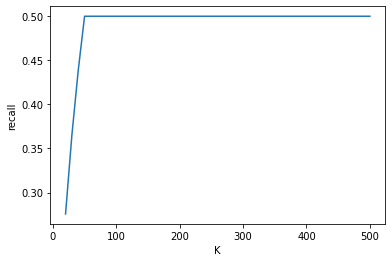

In [35]:
sns.lineplot(data = recall_df, x = 'K', y = 'recall')

**Заключение**  
1. Из всех четырех опробованных способов наилучшие результаты по показателю recall@k показал метод get_own_recommendations.
2. Если верить полученному результату, то после поределенной величины k влияние на recall исчезает и величина сетрики стабилизируется.
3. Для данного конкретного датасета значение к > 50 не имеет смысла. Максимум достигается при величине между 40 и 50. возможно это связано со средним количеством покупок для одного юзера.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

Precision@k рассчитанный для набора с самым высоким recall@k при k=5

In [36]:
result_lvl_1.apply(lambda row: m.precision_at_k(row['own'], row['item_id'], k=5), axis=1).mean()

0.8763927855711422

Работа с моделью второго уровня.

In [37]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

In [38]:
users_lvl_2.head()

,user_id
0,2070
1,2021
2,1753
3,2120
4,1346


In [42]:
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [43]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [44]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [45]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [46]:
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

In [47]:
users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [48]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

In [46]:
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

In [47]:
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [49]:
targets_lvl_2.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [50]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [51]:
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1019940,1,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2021,840361,1,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,856060,1,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Воспользуемся примерами дополнительных признаков из лекции

In [53]:
data_train_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


In [54]:
tmp_df = data_train_lvl_2[['user_id', 'day', 'item_id', 'quantity', 'sales_value']]

In [57]:
tmp_df = tmp_df[tmp_df['user_id'].isin(train_users)]

In [59]:
tmp_df.shape

(169615, 5)

In [60]:
tmp_df.head()

,user_id,day,item_id,quantity,sales_value
2104867,2070,594,1019940,1,1.00
2107468,2021,594,840361,1,0.99
2107469,2021,594,856060,1,1.77
2107470,2021,594,869344,1,1.67
2107471,2021,594,896862,2,5.00


Превышение числа покупок относительного среднего уровня покупок

In [65]:
avg_buy = pd.DataFrame(tmp_df[['user_id', 'day', 'quantity']].groupby('user_id').agg({'quantity':'sum'}))
avg_buy.head()

,quantity
user_id,
1,148
2,84
4,38
6,141
7,116


In [66]:
avg_buy['disp'] = (avg_buy['quantity'] - avg_buy['quantity'].mean())/avg_buy['quantity'].mean()

In [67]:
avg_buy.drop('quantity', axis=1, inplace = True)

In [68]:
avg_buy.head()

,disp
user_id,
1,-0.982625
2,-0.990138
4,-0.995539
6,-0.983446
7,-0.986381


In [ ]:
#фичи для товара

In [ ]:
#фичи для item-user

In [71]:
targets_lvl_2 = targets_lvl_2.merge(avg_buy, how='left', on='user_id')

In [72]:
targets_lvl_2

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,disp_x,disp_y
0,2070,1019940,1,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.060393,1.060393
1,2021,840361,1,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.991312,-0.991312
2,2021,856060,1,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.991312,-0.991312
3,2021,869344,1,69,GROCERY,Private,FRZN VEGETABLE/VEG DSH,FRZN BAGGED VEGETABLES - PLAIN,16 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.991312,-0.991312
4,2021,896862,1,1425,MEAT-PCKGD,National,BACON,ECONOMY,1 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.991312,-0.991312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169706,222,1120741,1,69,GROCERY,Private,SOFT DRINKS,SFT DRNK 2 LITER BTL CARB INCL,2 LTR,35-44,A,35-49K,Unknown,2 Adults No Kids,2,None/Unknown,-0.984855,-0.984855
169707,462,993339,1,69,GROCERY,Private,YOGURT,YOGURT NOT MULTI-PACKS,32 OZ,65+,U,100-124K,Unknown,Single Male,1,None/Unknown,-0.994013,-0.994013
169708,462,995242,1,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,65+,U,100-124K,Unknown,Single Male,1,None/Unknown,-0.994013,-0.994013
169709,462,10180324,1,69,MEAT-PCKGD,Private,LUNCHMEAT,MISCELLANEOUS,8OZ,65+,U,100-124K,Unknown,Single Male,1,None/Unknown,-0.994013,-0.994013


In [126]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [127]:
cat_feats = X_train.columns[2:].tolist()

In [128]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [129]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [130]:
X_train['preds'] = train_preds

In [131]:
X_train['y_true'] = y_train

In [132]:
# your code
# X_val подготовить из data_val_lvl_2 также как и X_train из targets_lvl_2
# val_preds = lgb.predict(X_val) #, где X_val - датасет подготовленный по аналогии с data_train_lvl_2

In [133]:
data_val_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.2,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.0,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.0,112,92,0.0,0.0


Применим преобразования к датасету.

In [134]:
tmp_df_val = data_val_lvl_2[['user_id', 'day', 'item_id', 'quantity', 'sales_value']]
tmp_df_val = tmp_df_val[tmp_df_val['user_id'].isin(train_users)]
avg_buy_val = pd.DataFrame(tmp_df_val[['user_id', 'day', 'quantity']].groupby('user_id').agg({'quantity':'sum'}))
avg_buy_val['disp'] = (avg_buy_val['quantity'] - avg_buy_val['quantity'].mean())/avg_buy_val['quantity'].mean()
avg_buy_val.drop('quantity', axis=1, inplace = True)
targets_lvl_2_val = targets_lvl_2.merge(avg_buy_val, how='left', on='user_id')

In [135]:
X_val = targets_lvl_2_val.drop('target', axis=1)

In [136]:
y_val = targets_lvl_2_val[['target']]
cat_feats_val = X_val.columns[2:].tolist()
X_val[cat_feats_val] = X_val[cat_feats_val].astype('category')

In [137]:
X_val.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'disp_x',
       'disp_y', 'disp'],
      dtype='object')

In [138]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'disp_x',
       'disp_y', 'preds', 'y_true'],
      dtype='object')

In [139]:
X_val.drop('disp', axis=1, inplace=True)

In [140]:
val_preds = lgb.predict(X_val)

In [141]:
X_val['preds'] = val_preds

In [142]:
X_val['y_true'] = y_val

Расчет метрик для тестового датасета

In [143]:
train_data_result = X_train[X_train['y_true']>0].groupby('user_id')['item_id'].agg(list).reset_index()

In [144]:
preds = X_train[X_train['preds']>0].groupby('user_id')['item_id'].agg(list).reset_index()

In [145]:
train_data_result.rename(columns={'item_id':'actual'}, inplace = True)

In [146]:
train_data_result = train_data_result.merge(preds, how='left', on='user_id')

In [147]:
train_data_result.rename(columns={'item_id':'lightGBM'}, inplace = True)

In [148]:
train_data_result.apply(lambda row: m.precision_at_k(row['lightGBM'], row['actual']), axis=1).mean()

1.3935933147632313

In [156]:
from sklearn.metrics import roc_auc_score

Расчет метрик для валидационного датасета

In [149]:
val_data_result = X_val[X_val['y_true']>0].groupby('user_id')['item_id'].agg(list).reset_index()

In [150]:
preds_val = X_val[X_val['preds']>0].groupby('user_id')['item_id'].agg(list).reset_index()

In [151]:
val_data_result.rename(columns={'item_id':'actual'}, inplace = True)

In [152]:
val_data_result = val_data_result.merge(preds_val, how='left', on='user_id')

In [153]:
val_data_result.rename(columns={'item_id':'lightGBM'}, inplace = True)

In [154]:
val_data_result.apply(lambda row: m.precision_at_k(row['lightGBM'], row['actual']), axis=1).mean()

1.3935933147632313

Исключительно странная ситуация связанная с совпадением величин метрик, но так как расчет выполнялся независимо, получается, результат следует принять как есть.

# Задание 3


X_val подготовить из data_val_lvl_2 также как и X_train из targets_lvl_2
val_preds = lgb.predict(X_val) #, где X_val - датасет подготовленный по аналогии с data_train_lvl_2

Далее оценить на валидационном множестве precision

Сравнить с трейном (у меня было 0.78782)

In [52]:
# your_code
#См. в тексте задания 2.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 